In [2]:
import movingpandas as mp # needed to delete line calling contextily from trajectory.py
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import geopandas as gpd
from shapely.geometry import Point, Polygon
import warnings
import matplotlib.pyplot as plt
import descartes
import pyproj

plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline 
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Reading the data sample data

The data corresponds to the records of one user. The data I am going to use in my project has data for different users. I divided this data into three different users just to make it more similar to the data I will use.

In [3]:
# read the sample data
gps = pd.read_csv('./sample_data/traj_full.csv')
gps.head()

,trID,trN,pIdx,X,Y,time,duration
0,a,1,1,7.213,50.772,04/12/2006 19:14:41,0
1,a,1,2,7.213,50.772,04/12/2006 19:14:45,0
2,a,1,3,7.212,50.772,04/12/2006 19:14:51,0
3,a,1,4,7.212,50.772,04/12/2006 19:14:55,0
4,a,1,5,7.211,50.771,04/12/2006 19:15:00,0


In [21]:
gps = gps.sort_values(by=['trID', 'time'])
gps['date_time'] = pd.to_datetime(gps['time'])
gps.shape

(112537, 9)

In [22]:
# Here I create three users A, B and C
ids = np.array(["A", "B", "C"])
gps['user_id'] = np.repeat(ids, [37000, 37000, 38537], axis=0)

In [6]:
# I converted the timestamp to datetime class and assigned it as the index of the pandas dataframe 
trips = gps.set_index('date_time')
lon_lat = [Point(xy) for xy in zip(trips.X, trips.Y)]
crs = {'init': 'epsg:4326'}
trips = gpd.GeoDataFrame(trips, crs=crs, geometry=lon_lat)
trips.head()

,trID,trN,pIdx,X,Y,time,duration,user_id,geometry
date_time,,,,,,,,,
2007-01-01 14:40:36,a,1,8745,7.203,50.780,01/01/2007 14:40:36,0,A,POINT (7.202585000000001 50.779636)
2007-01-01 14:40:39,a,1,8746,7.203,50.780,01/01/2007 14:40:39,0,A,POINT (7.20273 50.779854)
2007-01-01 14:40:43,a,1,8747,7.203,50.780,01/01/2007 14:40:43,0,A,POINT (7.202917 50.78012)
2007-01-01 14:40:46,a,1,8748,7.203,50.780,01/01/2007 14:40:46,0,A,POINT (7.203072 50.78035999999999)
2007-01-01 14:40:49,a,1,8749,7.203,50.781,01/01/2007 14:40:49,0,A,POINT (7.203155000000001 50.78064000000001)


In [8]:
# to make everything faster I just selected the first 300 observations for each user
trips = trips.groupby('user_id').head(300)
trips.head()

,trID,trN,pIdx,X,Y,time,duration,user_id,geometry
date_time,,,,,,,,,
2007-01-01 14:40:36,a,1,8745,7.203,50.780,01/01/2007 14:40:36,0,A,POINT (7.202585000000001 50.779636)
2007-01-01 14:40:39,a,1,8746,7.203,50.780,01/01/2007 14:40:39,0,A,POINT (7.20273 50.779854)
2007-01-01 14:40:43,a,1,8747,7.203,50.780,01/01/2007 14:40:43,0,A,POINT (7.202917 50.78012)
2007-01-01 14:40:46,a,1,8748,7.203,50.780,01/01/2007 14:40:46,0,A,POINT (7.203072 50.78035999999999)
2007-01-01 14:40:49,a,1,8749,7.203,50.781,01/01/2007 14:40:49,0,A,POINT (7.203155000000001 50.78064000000001)


## Create Linestrings

Here I use the movingpandas library from Anita Graser. Basically, I create a trajectory per user with all their GPS points

In [9]:
t_start = datetime.now()
trajectories = []
for key, values in trips.groupby(['user_id']):
    trajectory = mp.Trajectory(key, values)
    trajectories.append(trajectory)
    print("Finished creating {} trajectories in {}".format(len(trajectories), datetime.now() - t_start))  

Finished creating 1 trajectories in 0:00:00.003790
Finished creating 2 trajectories in 0:00:00.004787
Finished creating 3 trajectories in 0:00:00.045849


### How does the trajectory object looks like?

In [37]:
print(trajectories[0])

Trajectory A (2007-01-01 14:40:36 to 2007-01-02 09:38:31) | Size: 300 | Length: 8848.2m
Bounds: (7.19689, 50.75238, 7.218432000000001, 50.794907)
LINESTRING (7.202585000000001 50.779636, 7.20273 50.779854, 7.202917 50.78012, 7.203072 50.780359999


In [50]:
# the trajectory is stroed as a linestring and also as regular dataframe with columns and rows
# trajectory as dataframe
trajectories[0].df.head()

,trID,trN,pIdx,X,Y,time,duration,user_id,geometry
date_time,,,,,,,,,
2007-01-01 14:40:36,a,1,8745,7.203,50.780,01/01/2007 14:40:36,0,A,POINT (7.202585000000001 50.779636)
2007-01-01 14:40:39,a,1,8746,7.203,50.780,01/01/2007 14:40:39,0,A,POINT (7.20273 50.779854)
2007-01-01 14:40:43,a,1,8747,7.203,50.780,01/01/2007 14:40:43,0,A,POINT (7.202917 50.78012)
2007-01-01 14:40:46,a,1,8748,7.203,50.780,01/01/2007 14:40:46,0,A,POINT (7.203072 50.78035999999999)
2007-01-01 14:40:49,a,1,8749,7.203,50.781,01/01/2007 14:40:49,0,A,POINT (7.203155000000001 50.78064000000001)


In [51]:
# trajectory as linestring
# Get the first lon lat coordiantes of the trajectory
trajectories[0].to_linestring().coords[0:9]

[(7.202585000000001, 50.779635999999996),
 (7.20273, 50.779854),
 (7.202917, 50.780120000000004),
 (7.203072, 50.780359999999995),
 (7.203155000000001, 50.780640000000005),
 (7.203102, 50.780945),
 (7.202978, 50.781254),
 (7.20287, 50.781544),
 (7.202797, 50.78188)]

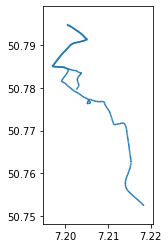

In [52]:
# How doe slook like the trajectory of user 0 (user A)
trajectories[0].plot()

In [57]:
# I can also extract the coordiantes in WKT format (i.e POINT(7.202585000000001 50.779636))
trajectories[0].df.geometry.head()

date_time
2007-01-01 14:40:36            POINT (7.202585000000001 50.779636)
2007-01-01 14:40:39                      POINT (7.20273 50.779854)
2007-01-01 14:40:43                      POINT (7.202917 50.78012)
2007-01-01 14:40:46             POINT (7.203072 50.78035999999999)
2007-01-01 14:40:49    POINT (7.203155000000001 50.78064000000001)
Name: geometry, dtype: object

In [59]:
# an easy way to count the number of points in the trajectory
trajectories[0].df.geometry.count()

300

In [60]:
# specify projection for calculating spatial distances with proj library
geod = pyproj.Geod(ellps='WGS84')

## Extract charactheristics points

This corresponds to algorithm 1 in Andrienko's paper.

In [61]:
# Extract charactheristic points
# distance parameters are specified in meters, stop duration in seconds, 
# and angles in degrees. 
# The characteristic points should contain start and end locations, as well as turns and stop locations:
class Analyzer:
    def __init__(self,traj, max_distance, min_distance, min_stop_duration, min_angle = 45):
        self.i = 0 # initializing the indices
        self.j = 1
        self.k = 2
        self.traj = traj # corresponds to the input of the algorithm,the trajectory object of each user
        self.n = self.traj.df.geometry.count() # I do this to get the number of points/GPS records of the trajectory
        self.max_distance = max_distance # parameter that I need to specify
        self.min_distance = min_distance # parameter that I need to specify
        self.min_stop_duration = min_stop_duration # parameter that I need to specify
        self.min_angle = min_angle # parameter that I need to specify
        self.last_point_index = int(traj.df.geometry.count() - 1) # to obtain the index of the last coord of the trajectory
        # Below I obtain extract the first significant points of the trajectory, that is, the first and last lon lat coordiantes
        self.significant_points = [self.traj.to_linestring().coords[0],self.traj.to_linestring().coords[self.last_point_index]]
    
    # Start of algorithm ------------------------------------------------
    def find_significant_points(self): # this is the algorithm
        
        while self.j < self.n-1:
            
            #print(self.j)
            
            # function is_representative_max_distance is defined below the while loop, as well as the rest of the 
            # helper functions
            if self.is_representative_max_distance(): 
                #print("representative max distance at {0}".format(self.j))
                # with traj.to_linestring().coords[int(self.j)] I extract the jth coord of the trajectory
                self.significant_points.append(self.traj.to_linestring().coords[int(self.j)])
                # update the indices
                self.i = self.j
                self.j = self.i + 1
                # I commented out continue statement, doesnt seem to make any difference
                #continue 
                
            elif self.more_points_further_than_min_distance():
                if self.k > self.j + 1: 
                    # d_time equal to difference in seconds between point k-1 and point j
                    d_time = (self.traj.df.index[int(self.k-1)] - self.traj.df.index[int(self.j)]).total_seconds()
                    if d_time >= self.min_stop_duration: 
                        #print("significant stop ({1}) at {0}".format(self.j,d_time))
                        self.significant_points.append(self.traj.to_linestring().coords[int(self.j)])
                        self.i = self.j
                        self.j = self.k
                        #continue 
                    else:
                        # compute the average spatial position to represent the similar points
                        # Here I have a doubt, if I divide self.j + (self.k-1-self.j) by 2, sometimes the 
                        # result will not be an integer. Then, when I update the j index and try to use 
                        # it for accesing the jth element of a trajectory, it will return an error. Thats why
                        # I decided to use integer division, so the return number is always an integer.
                        m = self.j + (self.k-1-self.j)//2 # had to use // instead of /
                        self.j = m # what is this m for?
                
                a_turn = self.compute_angle_between_vectors()
                #print("{0}: {1}".format(self.j,a_turn))
                if a_turn >= self.min_angle and a_turn <= (360-self.min_angle):
                    #print("significant angle ({0}) at {1}".format(a_turn,self.j))
                    self.significant_points.append(self.traj.to_linestring().coords[int(self.j)])
                    self.i = self.j
                    self.j = self.k
                else:
                    self.j += 1
                        
            else:
                return self.significant_points
        
        return self.significant_points
    # end of algorithm ------------------------------------------------------------
   
    # here the helper functions that are called in the algorithm are defined.
    def compute_angle_between_vectors(self):
        # p_i = the ith point/lon lat coordiante of the trajectory e.g. (7.201938, 50.793915000000005)
        # I obtain the jth an kth coordiantes of the trajectory as well
        p_i = self.traj.to_linestring().coords[int(self.i)] 
        p_j = self.traj.to_linestring().coords[int(self.j)]
        p_k = self.traj.to_linestring().coords[int(self.k)]
        # I calculate the azimuth between point i and j. 
        # geod.inv returns three values, in the first position is the forward azimuth, in second position back azimuth
        # and in third position the distance. Here I just return the forward azimuth between point i and j
        azimuth_ij = geod.inv(p_i[0], p_i[1], p_j[0], p_j[1])[0] # in position 0 is azimuth 1 in position 2 is the distance. 
        
        # the same for point j and k
        azimuth_jk = geod.inv(p_j[0], p_j[1], p_k[0], p_k[1])[0]
        #print("{0} - {1}".format(azimuth_ij,azimuth_jk))
        # return absolute difference
        return abs(azimuth_ij - azimuth_jk) 
    
    def more_points_further_than_min_distance(self):
        for self.k in range(self.j+1,self.n):
            # get point j and k
            p_j = self.traj.to_linestring().coords[int(self.j)]
            p_k = self.traj.to_linestring().coords[int(self.k)]
            # calculate distance between both points
            d_space_j_k = geod.inv(p_j[0], p_j[1], p_k[0], p_k[1])[2]
            if d_space_j_k >= self.min_distance:
                return True
        return False
        
    def is_representative_max_distance(self):
        # I guess this is self explanatory now
        p_i = self.traj.to_linestring().coords[int(self.i)]
        p_j = self.traj.to_linestring().coords[int(self.j)]
        d_space = geod.inv(p_i[0], p_i[1], p_j[0], p_j[1])[2]
        
        if d_space >= self.max_distance:
            self.significant_points.append(p_i)
            return True
        else:
            return False

In [62]:
# Here i use class Analyzer defiend in previous step to extract the charactheristic points of each trajectory
significant_points = []
for line in trajectories:
    a = Analyzer(traj = line, max_distance = 1000, min_distance = 100, min_stop_duration = 300, min_angle = 45)
    significant_points = significant_points + a.find_significant_points()

In [63]:
print("Number of significant points: {0}".format(len(significant_points)))

Number of significant points: 72


In [22]:
significant_points[1:10]

[(7.218432000000001, 50.75238),
 (7.203697, 50.783398),
 (7.197188000000001, 50.785156),
 (7.205189999999999, 50.79135),
 (7.200433, 50.794785),
 (7.20483, 50.791313),
 (7.19689, 50.785121999999994),
 (7.200432000000001, 50.784508),
 (7.1990419999999995, 50.781673)]

In [36]:
# Write significant points to csv file
out = open('significant_points.csv', 'w')
for row in significant_points:
    for column in row:
        out.write('{0},'.format(column))
    out.write('\n')
out.close()

## Group Points in Space